# Table of Contents


- Geting Started
    - Set Up Environment
    - Import Data
- Model Aggregator
    - Individual Cart Decision Tree
    - Individual Gradient Boosting
    - Individual Random Forest
    - Results
- Model Stacker

Note: this notebook is meant to be a demo of some of the capabilities of **`oo-learning`** (https://github.com/shane-kercheval/oo-learning); it is not meant to show the best approach to exploring/cleaning/modeling this particular dataset. Also, with most graphs (e.g. correlations/box-plots/etc.) I will spend very little time commenting on the significance of any interesting or patterns. Again, the intent is to show a demo, not a guide to data analysis. 



# Getting Started

In this notebook, we'll see how to search across different models and hyper-parameters (or the same models and hyper-parameters with different transformations, for example) with the goal of finding the "best" or ideal model candidates for further tuning and optimization.

## Set Up Environment

In [1]:
# !pip install oolearning --upgrade

In [2]:
from oolearning import *
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

## Import Data

`ExploreRegressionDataset` is a convenience class described in the [first notebook of this series](https://github.com/shane-kercheval/oo-learning/blob/master/examples/regression-insurance/1-Exploring.ipynb).

In [3]:
csv_file = '../data/insurance.csv'
target_variable = 'expenses'

explore = ExploreRegressionDataset.from_csv(csv_file_path=csv_file,
                                            target_variable=target_variable)

In [4]:
explore.dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


# Model Aggregator

We'll use a **`Model Aggregator`** to take the predictions of several models (in this example, a `cart decision tree`, `gradient booster`, and a `random forest`) and use the median of the predictions as the final (aggregated) prediction. We'll compare the results of the individual models to the result of the Aggregator.

## Individual Cart Decision Tree

In [5]:
cart_trainer = ModelTrainer(model=CartDecisionTreeRegressor(),
                            model_transformations=[DummyEncodeTransformer(CategoricalEncoding.DUMMY)],
                            splitter=RegressionStratifiedDataSplitter(holdout_ratio=0.3),
                            evaluator=RegressionEvaluator())
cart_trainer.train(data=explore.dataset,
                   target_variable='expenses',
                   hyper_params=CartDecisionTreeHP(criterion='mae'))

cart_trainer.holdout_evaluator.all_quality_metrics

{'Mean Absolute Error (MAE)': 2919.641119402987,
 'Mean Squared Error (MSE)': 43168547.5099719,
 'RMSE to Standard Deviation of Target': 0.5437440842368935,
 'Root Mean Squared Error (RMSE)': 6570.277582413996,
 'Total Observations': 402}

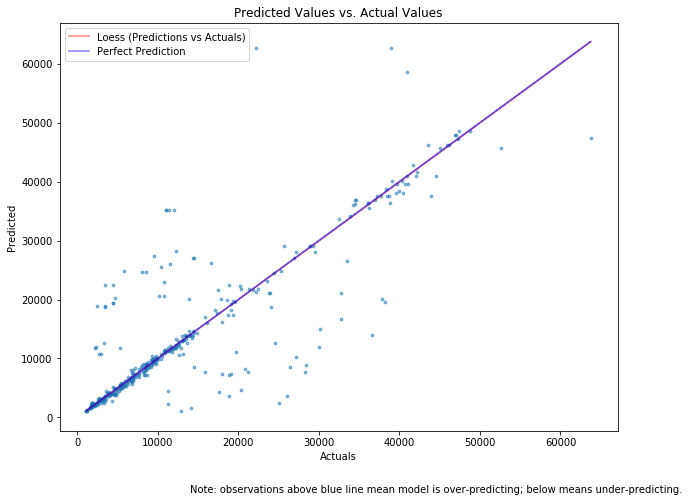

In [6]:
cart_trainer.holdout_evaluator.plot_predictions_vs_actuals()

## Individual Gradient Boosting

In [7]:
gbr_trainer = ModelTrainer(model=GradientBoostingRegressor(),
                           model_transformations=[DummyEncodeTransformer(CategoricalEncoding.DUMMY)],
                           splitter=RegressionStratifiedDataSplitter(holdout_ratio=0.3),
                           evaluator=RegressionEvaluator())
gbr_trainer.train(data=explore.dataset,
                  target_variable='expenses',
                  hyper_params=GradientBoostingRegressorHP())

gbr_trainer.holdout_evaluator.all_quality_metrics

{'Mean Absolute Error (MAE)': 2613.4835461484795,
 'Mean Squared Error (MSE)': 21654660.918443073,
 'RMSE to Standard Deviation of Target': 0.3851115294754094,
 'Root Mean Squared Error (RMSE)': 4653.456878326378,
 'Total Observations': 402}

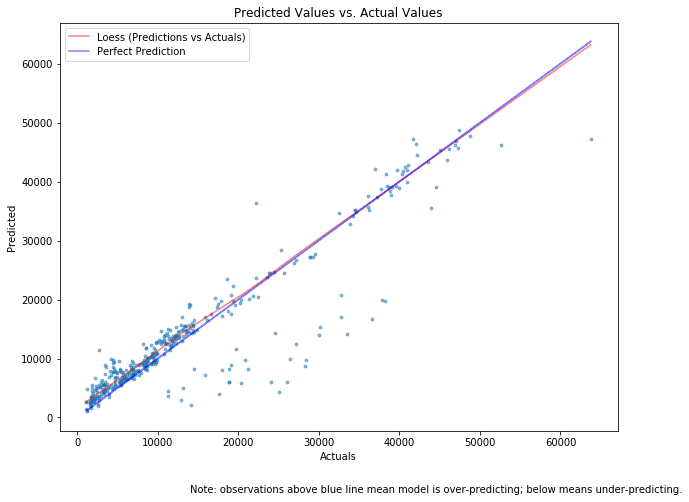

In [8]:
gbr_trainer.holdout_evaluator.plot_predictions_vs_actuals()

## Individual Random Forest

In [9]:
rf_trainer = ModelTrainer(model=RandomForestRegressor(),
                          model_transformations=[DummyEncodeTransformer(CategoricalEncoding.DUMMY)],
                          splitter=RegressionStratifiedDataSplitter(holdout_ratio=0.3),
                          evaluator=RegressionEvaluator())
rf_trainer.train(data=explore.dataset,
                 target_variable='expenses',
                 hyper_params=RandomForestHP(criterion='mae'))

rf_trainer.holdout_evaluator.all_quality_metrics

{'Mean Absolute Error (MAE)': 2766.188262537308,
 'Mean Squared Error (MSE)': 24485564.77195544,
 'RMSE to Standard Deviation of Target': 0.4095112996363123,
 'Root Mean Squared Error (RMSE)': 4948.289075221398,
 'Total Observations': 402}

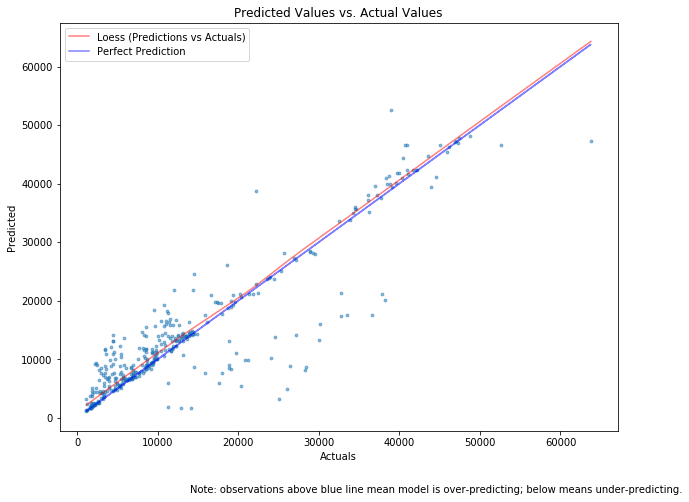

In [10]:
rf_trainer.holdout_evaluator.plot_predictions_vs_actuals()

## Model Aggregator Using Previous Models

Now let's use the model types as above, and aggregator their results.

In [11]:
model_infos = [ModelInfo(model=CartDecisionTreeRegressor(),
                         hyper_params=CartDecisionTreeHP(criterion='mae'),
                         transformations=[DummyEncodeTransformer(CategoricalEncoding.DUMMY)]),
               ModelInfo(model=GradientBoostingRegressor(),
                         hyper_params=GradientBoostingRegressorHP(),
                         transformations=[DummyEncodeTransformer(CategoricalEncoding.DUMMY)]),
               ModelInfo(model=RandomForestRegressor(),
                         hyper_params=RandomForestHP(criterion='mae'),
                         transformations=[DummyEncodeTransformer(CategoricalEncoding.DUMMY)])]

In [12]:
trainer_agg = ModelTrainer(model= ModelAggregator(base_models=model_infos,
                                                  aggregation_strategy=MedianAggregationStrategy()),
                       model_transformations=None,
                       splitter=RegressionStratifiedDataSplitter(holdout_ratio=0.3),
                       evaluator=RegressionEvaluator())
trainer_agg.train(data=explore.dataset, target_variable='expenses', hyper_params=None)

# access the holdout metrics (we also have `training_evaluator` available to us as well!) and get a summary
trainer_agg.holdout_evaluator.all_quality_metrics

{'Mean Absolute Error (MAE)': 2473.126151469182,
 'Mean Squared Error (MSE)': 23370347.888384037,
 'RMSE to Standard Deviation of Target': 0.400076843922416,
 'Root Mean Squared Error (RMSE)': 4834.2887675835045,
 'Total Observations': 402}

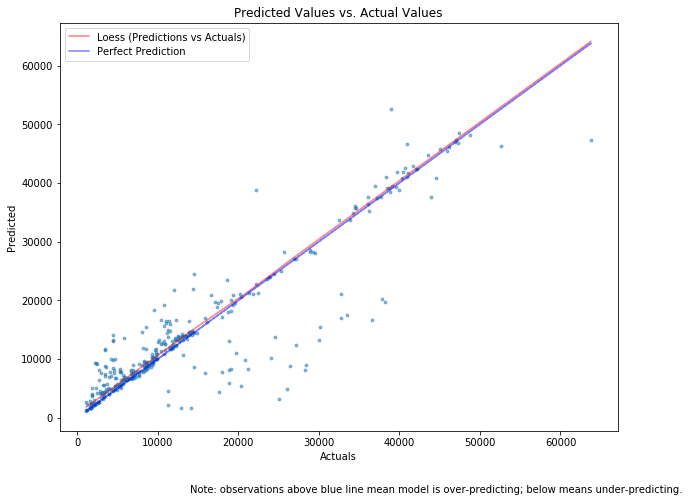

In [13]:
trainer_agg.holdout_evaluator.plot_predictions_vs_actuals()

## Results

Cart MAE:

In [14]:
cart_trainer.holdout_evaluator.mean_absolute_error

2919.641119402987

Gradient Boosting MAE:

In [15]:
gbr_trainer.holdout_evaluator.mean_absolute_error

2613.4835461484795

Random Forest MAE:

In [16]:
rf_trainer.holdout_evaluator.mean_absolute_error

2766.188262537308

Aggregator (using the median of the previous model's predictions) MAE:

In [17]:
trainer_agg.holdout_evaluator.mean_absolute_error

2473.126151469182

Notice that the Model Aggregator's MAE (using the median prediction) is lower than any of the individual model's MAE.

# Model Stacker

Define the same models we used in the model aggregator:

In [18]:
model_infos = [ModelInfo(description='cart',
                         model=CartDecisionTreeRegressor(),
                         hyper_params=CartDecisionTreeHP(criterion='mae'),
                         transformations=[DummyEncodeTransformer(CategoricalEncoding.DUMMY)]),
               ModelInfo(description='gradient boosting',
                         model=GradientBoostingRegressor(),
                         hyper_params=GradientBoostingRegressorHP(),
                         transformations=[DummyEncodeTransformer(CategoricalEncoding.DUMMY)]),
               ModelInfo(description='random forest',
                         model=RandomForestRegressor(),
                         hyper_params=RandomForestHP(criterion='mae'),
                         transformations=[DummyEncodeTransformer(CategoricalEncoding.DUMMY)])]

In [19]:
model_stacker = ModelStacker(base_models=model_infos,
                             scores=[MaeScore(), RmseScore()],
                             stacking_model=AdaBoostRegressor(),
                             stacking_transformations=None)

trainer_stacker = ModelTrainer(model=model_stacker,
                               model_transformations=None,
                               splitter=RegressionStratifiedDataSplitter(holdout_ratio=0.3),
                               evaluator=RegressionEvaluator())

trainer_stacker.train(data=explore.dataset, target_variable='expenses', hyper_params=AdaBoostRegressorHP())

In [20]:
trainer_stacker.holdout_evaluator.mean_absolute_error

2397.2828358208944

Notice that the Model Stacker's MAE is lower than Model Aggregator's MAE.